In [1]:
# Import des dépendances
import matplotlib.pyplot as plt
import matplotlib.widgets as widgets
import pandas as pd
import scipy as sp
import numpy as np
import calendar

In [18]:
## Définition de plusieurs fonctions réutilisées par la suite

# Définition d'une fonctions permettant de récupérer la prochaine valeur existante
def getNextCorrectValue(df, rowIndex, columnIndex):
    nextValue = df.iloc[(rowIndex + 1), columnIndex]
    if np.isnan(nextValue):
        return getNextCorrectValue(df, rowIndex+2, columnIndex)
    else:
        return nextValue


# Définition d'une fonctions permettant de récupérer la précédente valeur existante
def getPreviousCorrectValue(df, rowIndex, columnIndex):
    nextValue = df.iloc[(rowIndex-1), columnIndex]
    if np.isnan(nextValue):
        return getNextCorrectValue(df, rowIndex-2, columnIndex)
    else:
        return nextValue


# Définition d'une fonction permettant de calculer la moyenne par tableau de nombre
def getAveragePerArray(arrayOfArray):
    average_per_array=[]

    # Calcul de la moyenne par mois

    for index in range(len(arrayOfArray)):
        average_per_array.append(np.average(arrayOfArray[index]))
    
    return average_per_array


# Définition d'une fonction permettant de calculer l'écart type par tableau de nombre
def getStandardDeviationPerArray(arrayOfArray):
    standard_deviation_per_array=[]
    
    # Calcul de l'écart type de température par mois
    
    for index in range(len(arrayOfArray)):
        standard_deviation_per_array.append(np.std(arrayOfArray[index]))
        
    return standard_deviation_per_array


# Définition d'une fonction qui trouve le minimum et le maxium dans une array par array
def getMinAndMaxPerArray(arrayOfArray):
    
    min_per_array=[]
    max_per_array=[]
    
    # Détermination du minimum et maximum par array
    for index in range(len(arrayOfArray)):
        min_per_array.append(min(arrayOfArray[index]))
        max_per_array.append(max(arrayOfArray[index]))
    
    return min_per_array, max_per_array


# Définition d'une lambda permettant de mettre à plat une array d'array
flatten = lambda t: [item for sublist in t for item in sublist]

# Définition d'une lambda de diviser une liste par une autre
calculateDeviation = lambda list1, list2 : [abs(round(i / j, 3)) for i, j in zip(list1, list2)]

# Définition d'une fonction qui permet d'afficher un pointeur
class SnaptoCursor(object):
    def __init__(self, ax, x, y):
        self.ax = ax
        self.ly = ax.axvline(color='k', alpha=0.2)  # the vert line
        self.marker, = ax.plot([0],[0], marker="o", color="crimson", zorder=3) 
        self.x = x
        self.y = y
        self.txt = ax.text(0.7, 0.9, '')

    def mouse_move(self, event):
        if not event.inaxes: return
        x, y = event.xdata, event.ydata
        indx = np.searchsorted(self.x, [x])[0]
        x = self.x[indx]
        y = self.y[indx]
        self.ly.set_xdata(x)
        self.marker.set_data([x],[y])
        self.txt.set_text('%1.2f°C (day %1d)' % (y, x))
        self.txt.set_position((x,y))
        self.ax.figure.canvas.draw_idle()

In [3]:
# Définition d'une tableau contenant les températures par mois et par set de données
temperatures=[]

# Définition d'une tableau contenant la moyenne des températures par mois et par set de données
temperatures_averages=[]

# Définition d'une tableau contenant l'écart type des températures par mois et par set de données
temperatures_standard_deviation=[]

# Définition d'une tableau contenant le minimum et le maximum des températures par mois et par set de données
temperatures_min_per_month=[]
temperatures_max_per_month=[]

### Traitement sur le fichier Climat.xlsx avec la feuille SI - Erreur ###

In [4]:
## Chargement de la page "SI - Erreur" du fichier "Climat.xlsx"

current_si = 0
si_erreur = pd.read_excel("/home/jovyan/work/data/Climat.xlsx", sheet_name=1)

In [5]:
## Récupération des températures depuis l'excel pour le "SI OK"

temperature_si = []

for column in range(3, 15):
    month_temperature=[]
    for row in range(3, 34):
        temperature_value = si_erreur.iloc[row, column]
        
        # Si le type de la température n'est pas cohérent alors on fait la moyenne 
        # de la température précédente et suivante ayant au moins une valeur correcte
        if(type(temperature_value) is str):
            temperature_value = np.average([getNextCorrectValue(si_erreur, row, column), getPreviousCorrectValue(si_erreur, row, column)])

        # Si la valeur n'est pas nulle (pour un mois plus court comme février)
        # alors on ne prend pas cette valeur en compte
        if(not np.isnan((temperature_value))):
            month_temperature.append(temperature_value)

    temperature_si.append(month_temperature)

# On sauvegarde les données de ce set de données qui aura l'index 0
temperatures.append(temperature_si)

In [6]:
# Calcul des moyennes des températures
temperatures_averages.append(getAveragePerArray(temperatures[current_si]))

# Calcul des écarts-types des températures
temperatures_standard_deviation.append(getStandardDeviationPerArray(temperatures[current_si]))

In [7]:
# Maintenant que nous avons calculé un premier jet de nos moyennes et de nos écarts-types, 
# nous allons les utiliser pour trouver les nombres "atypiques". Ces nombres seront ensuite
# remplacés par la moyenne de la valeur précédente et suivante dans le tableau.

for month in range(len(temperatures[current_si])):
    # On considère qu'une valeur est fausse si elle n'est pas dans l'intervalle 
    # [(moyenne - multiplier * écart type du mois) ; (moyenne + multiplier * écart type du mois)]
    multiplier = 3
    min_interval = temperatures_averages[current_si][month] - multiplier * temperatures_standard_deviation[current_si][month]
    max_interval = temperatures_averages[current_si][month] + multiplier * temperatures_standard_deviation[current_si][month]
    
    for day_of_month in range(len(temperatures[current_si][month])):
        temperature_of_day = temperatures[current_si][month][day_of_month]
        if temperature_of_day < min_interval or temperature_of_day > max_interval:
            
            # On calcul la nouvelle valeur qui est la moyenne de la suivante et de la précédente
            new_temperature = int(np.average([temperatures[current_si][month][day_of_month - 1], temperatures[current_si][month][day_of_month + 1]]))
            temperatures[current_si][month][day_of_month] = new_temperature

In [8]:
# Calcul des moyennes des températures
temperatures_averages.append(getAveragePerArray(temperatures[current_si]))

# Calcul des écarts-types des températures
temperatures_standard_deviation.append(getStandardDeviationPerArray(temperatures[current_si]))

# Calcul des min et max des températures par mois
min_per_array, max_per_array = getMinAndMaxPerArray(temperatures[current_si])
temperatures_min_per_month.append(min_per_array)
temperatures_max_per_month.append(max_per_array)
print("Min temp {!s} and max temp {!s}".format(min(min_per_array), max(max_per_array)))

Min temp -19 and max temp 26


<IPython.core.display.Javascript object>


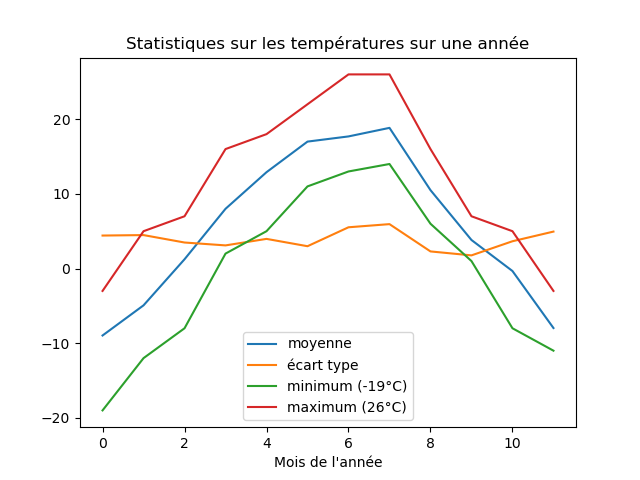

In [9]:
# Affichages des moyennes, des écarts-types et des min-max par mois
# dans un schéma pour que ce soit visuel

%matplotlib notebook

plot = plt.figure(month)
plt.plot(temperatures_averages[current_si], label = "moyenne")
plt.plot(temperatures_standard_deviation[current_si], label = "écart type")
plt.plot(temperatures_min_per_month[current_si], label = "minimum (" + str(min(temperatures_min_per_month[current_si])) + "°C)")
plt.plot(temperatures_max_per_month[current_si], label = "maximum (" + str(max(temperatures_max_per_month[current_si])) + "°C)")
plt.xlabel("Mois de l'année")
plt.title("Statistiques sur les températures sur une année")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


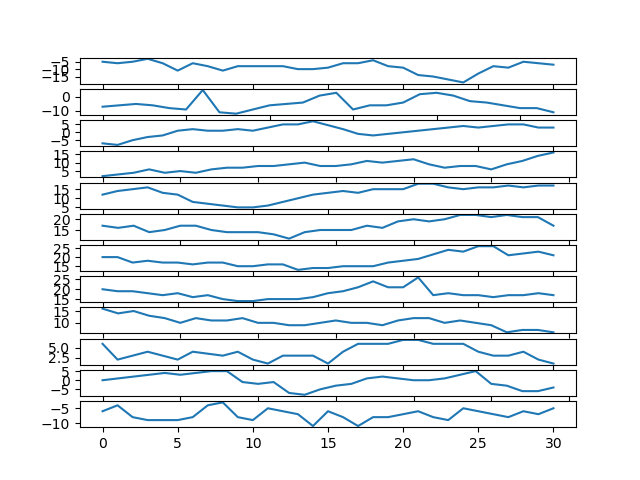

In [10]:
# Affichage de la température par mois via 1 figure

%matplotlib notebook

fig, axs = plt.subplots(len(temperatures[current_si]))

for month in range(len(temperatures[current_si])):
    axs[month].plot(temperatures[current_si][month])
    plt.show()

<IPython.core.display.Javascript object>


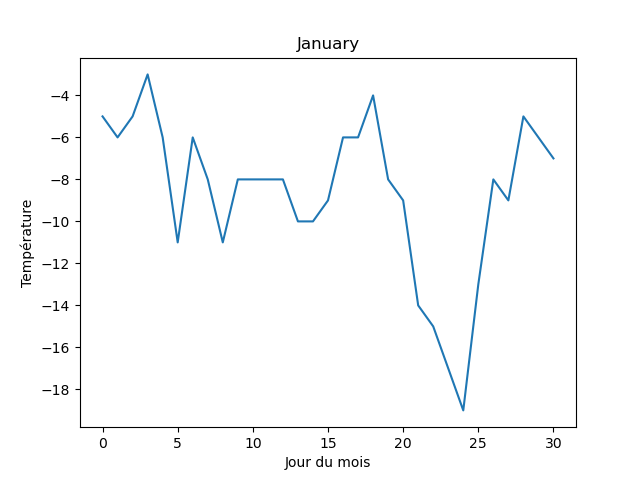

<IPython.core.display.Javascript object>


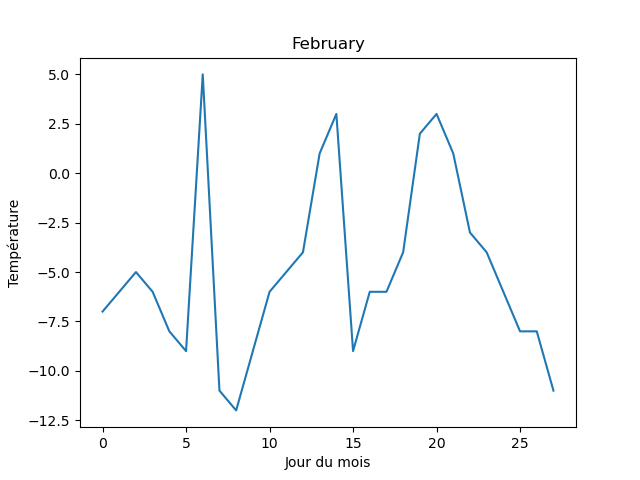

<IPython.core.display.Javascript object>


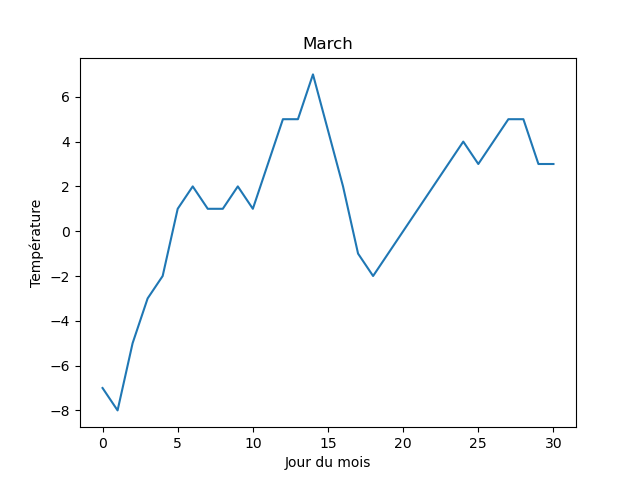

<IPython.core.display.Javascript object>


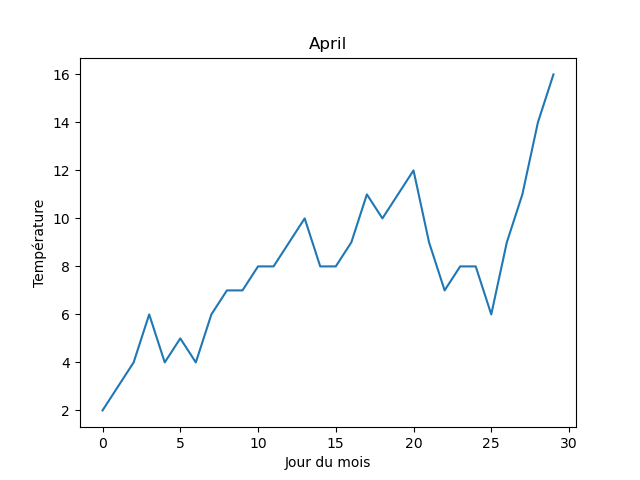

<IPython.core.display.Javascript object>


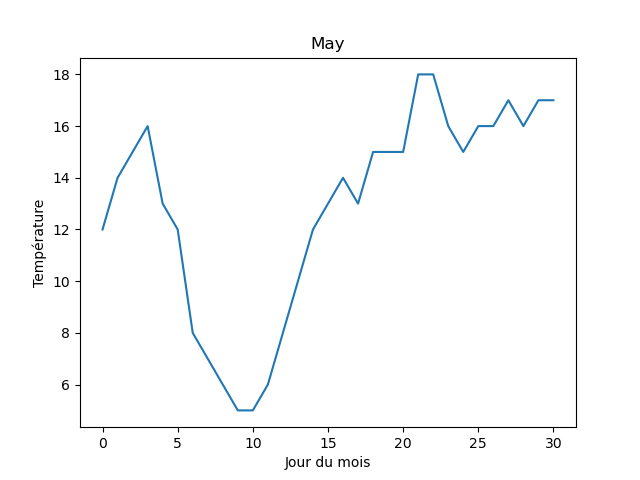

<IPython.core.display.Javascript object>


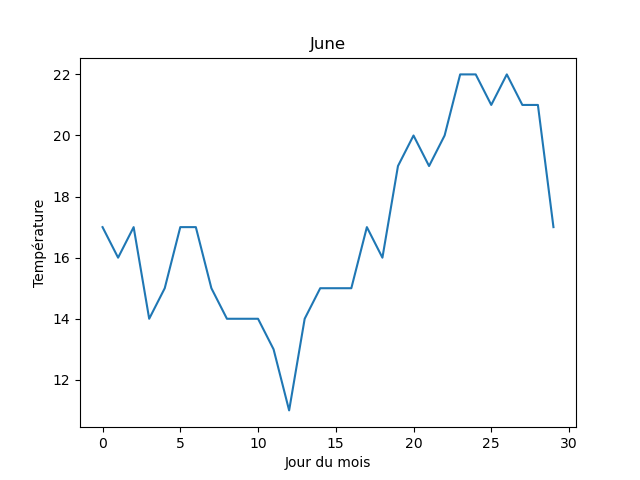

<IPython.core.display.Javascript object>


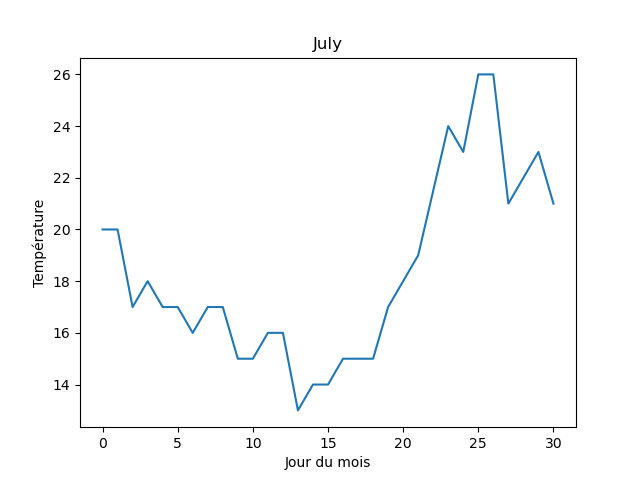

<IPython.core.display.Javascript object>


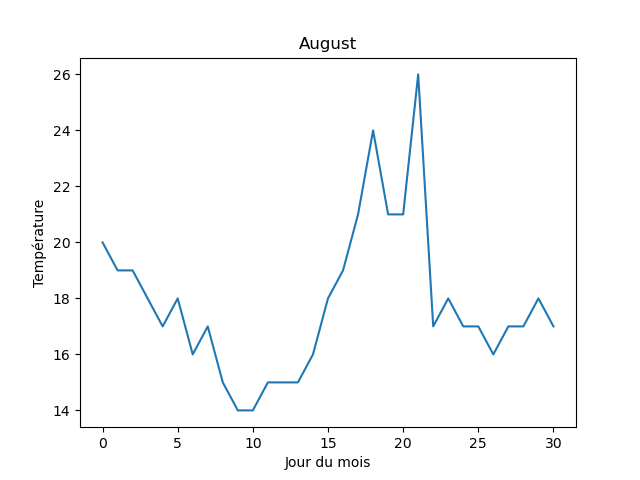

<IPython.core.display.Javascript object>


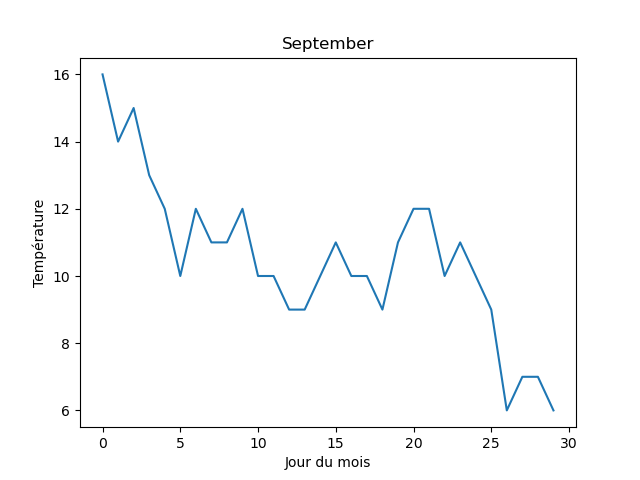

<IPython.core.display.Javascript object>


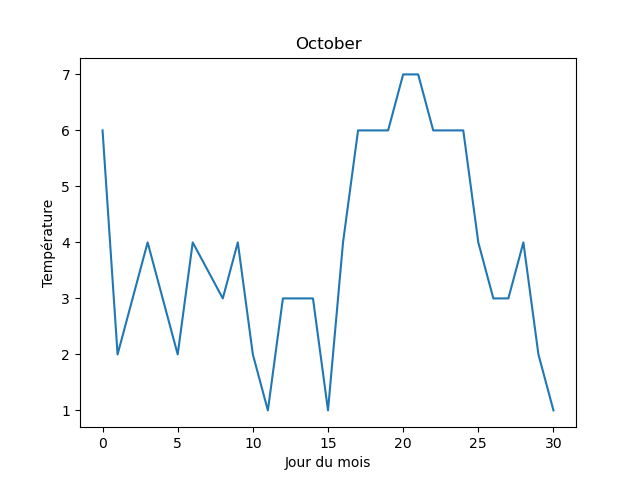

<IPython.core.display.Javascript object>


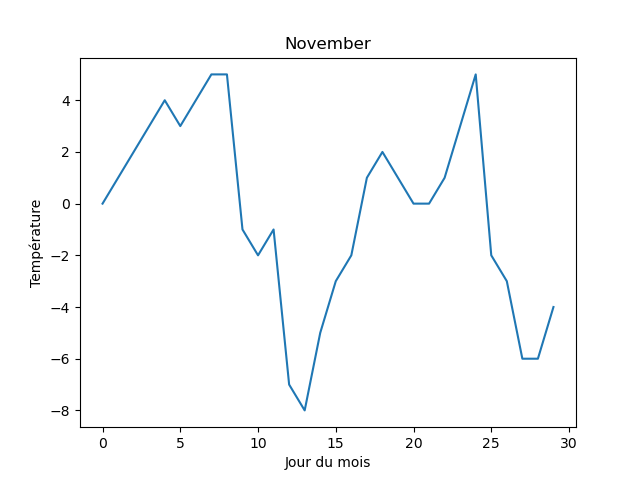

<IPython.core.display.Javascript object>


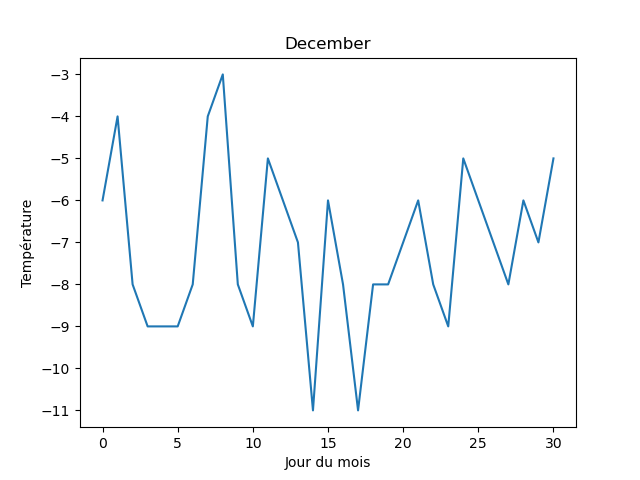

In [11]:
# Affichage de la température par mois via 12 figures

%matplotlib notebook

for month in range(len(temperatures[current_si])):
    plot = plt.figure(month)
    plt.title(calendar.month_name[month + 1])
    plt.plot(temperatures[current_si][month])
    plt.xlabel("Jour du mois")
    plt.ylabel("Température")

plt.show()

<IPython.core.display.Javascript object>


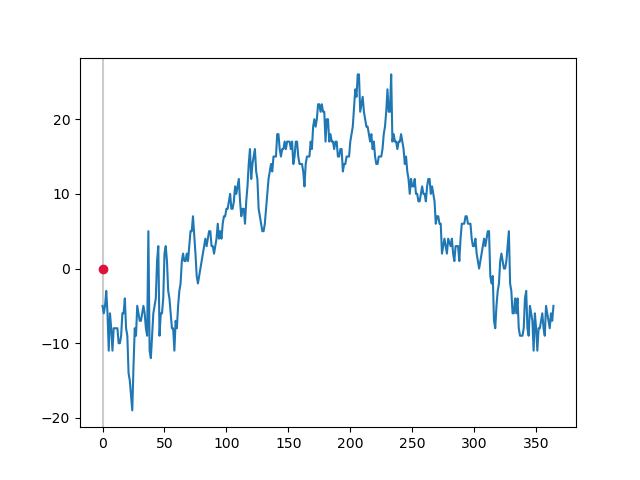

In [12]:
# Affichage de la température à l'année avec un curseur pour lire les valeurs

fig_range = np.arange(0, 365, 1)
fig, ax = plt.subplots()

cursor = SnaptoCursor(ax, fig_range, flatten(temperatures[current_si]))
cid =  plt.connect('motion_notify_event', cursor.mouse_move)

ax.plot(fig_range, flatten(temperatures[current_si]),)
plt.show()

### Traitement sur le fichier Savukoski kirkonkyla.xlsx ###

In [13]:
## Chargement de la page "SI - Erreur" du fichier "Savukoski kirkonkyla.xlsx"

current_si = 1
si_savukoski = pd.read_excel("/home/jovyan/work/data/Savukoski kirkonkyla.xlsx", sheet_name=2)

In [14]:
## Récupération des températures depuis l'excel pour le SI de Savukoski kirkonkyla
indexArray=[]
month = 1
month_temperature=[]
index = 1

temperature_si = []

for row in range(0, 365):
    temperature_value_max = si_savukoski.iloc[row, 6]
    temperature_value_min = si_savukoski.iloc[row, 7]
    # SI la valeur max est nulle, alors on va faire la moyenne entre les valeurs max 
    # du jour précédent et suivant ayant au moins une valeur correcte
    if(np.isnan(temperature_value_max)):
        temperature_value_max = np.average([getNextCorrectValue(si_savukoski, row, 6), getPreviousCorrectValue(si_savukoski, row, 6)])
    # SI la valeur min est nulle, alors on va faire la moyenne entre les valeurs min 
    # du jour précédent et suivant ayant au moins une valeur correcte
    if(np.isnan(temperature_value_min)):
        temperature_value_min = np.average([getNextCorrectValue(si_savukoski, row, 7), getPreviousCorrectValue(si_savukoski, row, 7)])
    # On sauvegarde la moyenne entre la température max et la température min
    month_temperature.append(int(np.average([temperature_value_max, temperature_value_min])))
    currentMonth = si_savukoski.iloc[row, 1]
    if currentMonth > month:
        temperature_si.append(month_temperature)
        month_temperature=[]
        month = currentMonth

temperature_si.append(month_temperature)

temperatures.append(temperature_si)

In [15]:
# Calcul des moyennes des températures
temperatures_averages.append(getAveragePerArray(temperatures[current_si]))

# Calcul des écarts-types des températures
temperatures_standard_deviation.append(getStandardDeviationPerArray(temperatures[current_si]))

# Calcul des min et max des températures par mois
min_per_array, max_per_array = getMinAndMaxPerArray(temperatures[current_si])
temperatures_min_per_month.append(min_per_array)
temperatures_max_per_month.append(max_per_array)
print("Min temp {!s} and max temp {!s}".format(min(min_per_array), max(max_per_array)))

Min temp -27 and max temp 24


<IPython.core.display.Javascript object>


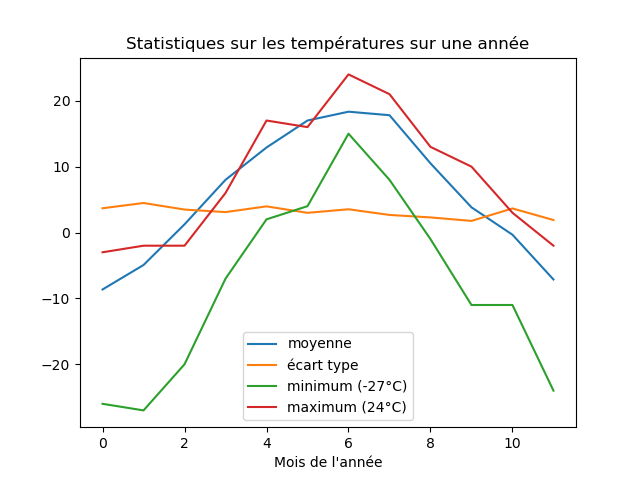

In [16]:
# Affichages des moyennes, des écarts-types et des min-max par mois
# dans un schéma pour que ce soit visuel

%matplotlib notebook

plot = plt.figure(month)
plt.plot(temperatures_averages[current_si], label = "moyenne")
plt.plot(temperatures_standard_deviation[current_si], label = "écart type")
plt.plot(temperatures_min_per_month[current_si], label = "minimum (" + str(min(temperatures_min_per_month[current_si])) + "°C)")
plt.plot(temperatures_max_per_month[current_si], label = "maximum (" + str(max(temperatures_max_per_month[current_si])) + "°C)")
plt.xlabel("Mois de l'année")
plt.title("Statistiques sur les températures sur une année")
plt.legend()
plt.show()

In [19]:
# On compare les écarts

print(calculateDeviation(temperatures_averages[0], temperatures_averages[1]))
print(calculateDeviation(temperatures_standard_deviation[0], temperatures_standard_deviation[1]))
print(calculateDeviation(temperatures_min_per_month[0], temperatures_min_per_month[1]))
print(calculateDeviation(temperatures_max_per_month[0], temperatures_max_per_month[1]))

[1.037, 1.0, 1.0, 1.0, 1.0, 1.0, 0.965, 1.058, 1.0, 1.0, 1.0, 1.118]
[1.199, 1.0, 1.0, 1.0, 1.0, 1.0, 1.566, 2.228, 1.0, 1.0, 1.0, 2.609]
[0.731, 0.444, 0.4, 0.286, 2.5, 2.75, 0.867, 1.75, 6.0, 0.091, 0.727, 0.458]
[1.0, 2.5, 3.5, 2.667, 1.059, 1.375, 1.083, 1.238, 1.231, 0.7, 1.667, 1.5]


On constate que l'écart pour la moyenne et l'écart type des témparatures par mois est faible excepté pour le mois de décembre et d'Aout.